<a href="https://colab.research.google.com/github/subah2004/Handwritten-digits-recognition-/blob/Pramod-Katchalla/cnn_and_fnn_handwritten_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
from torchvision import datasets,transforms
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
transform=transforms.Compose([transforms.ToTensor()])

In [ ]:
train_data=datasets.MNIST('data',train=True,download=True,transform=transform)
test_data=datasets.MNIST('data',train=False,download=True,transform=transform)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 138MB/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 26.7MB/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 36.7MB/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.21MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
valid_size=0.2
# IMPORTANT
batch_size=20

num_workers=0

train_length = len(train_data)

# obtain training dataset indices that will be used for validation dataset
indices = list(range(train_length))

np.random.shuffle(indices)
split = int(np.floor(valid_size * train_length))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders for train, test and validation dataset
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)

In [ ]:
# This is for debugging
train_idx.__len__(),valid_idx.__len__()

(48000, 12000)

In [ ]:
# Printing the length of our train, valid and test dataloaders
# NOTE : Here batch size is 20
len(train_loader),len(valid_loader),len(test_loader)

(2400, 600, 500)

In [ ]:
# checking our data
dataiter=iter(train_loader)
images,labels=dataiter.next()
print(images, images.shape, len(images), images[0].shape)
print()
print(labels,labels.shape,len(labels))

AttributeError: '_SingleProcessDataLoaderIter' object has no attribute 'next'

In [ ]:
# Checking our data
dataiter = iter(train_loader)
images, labels = next(dataiter)  # Use next(dataiter) instead of dataiter.next()

print(images, images.shape, len(images), images[0].shape)
print()
print(labels, labels.shape, len(labels))


tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

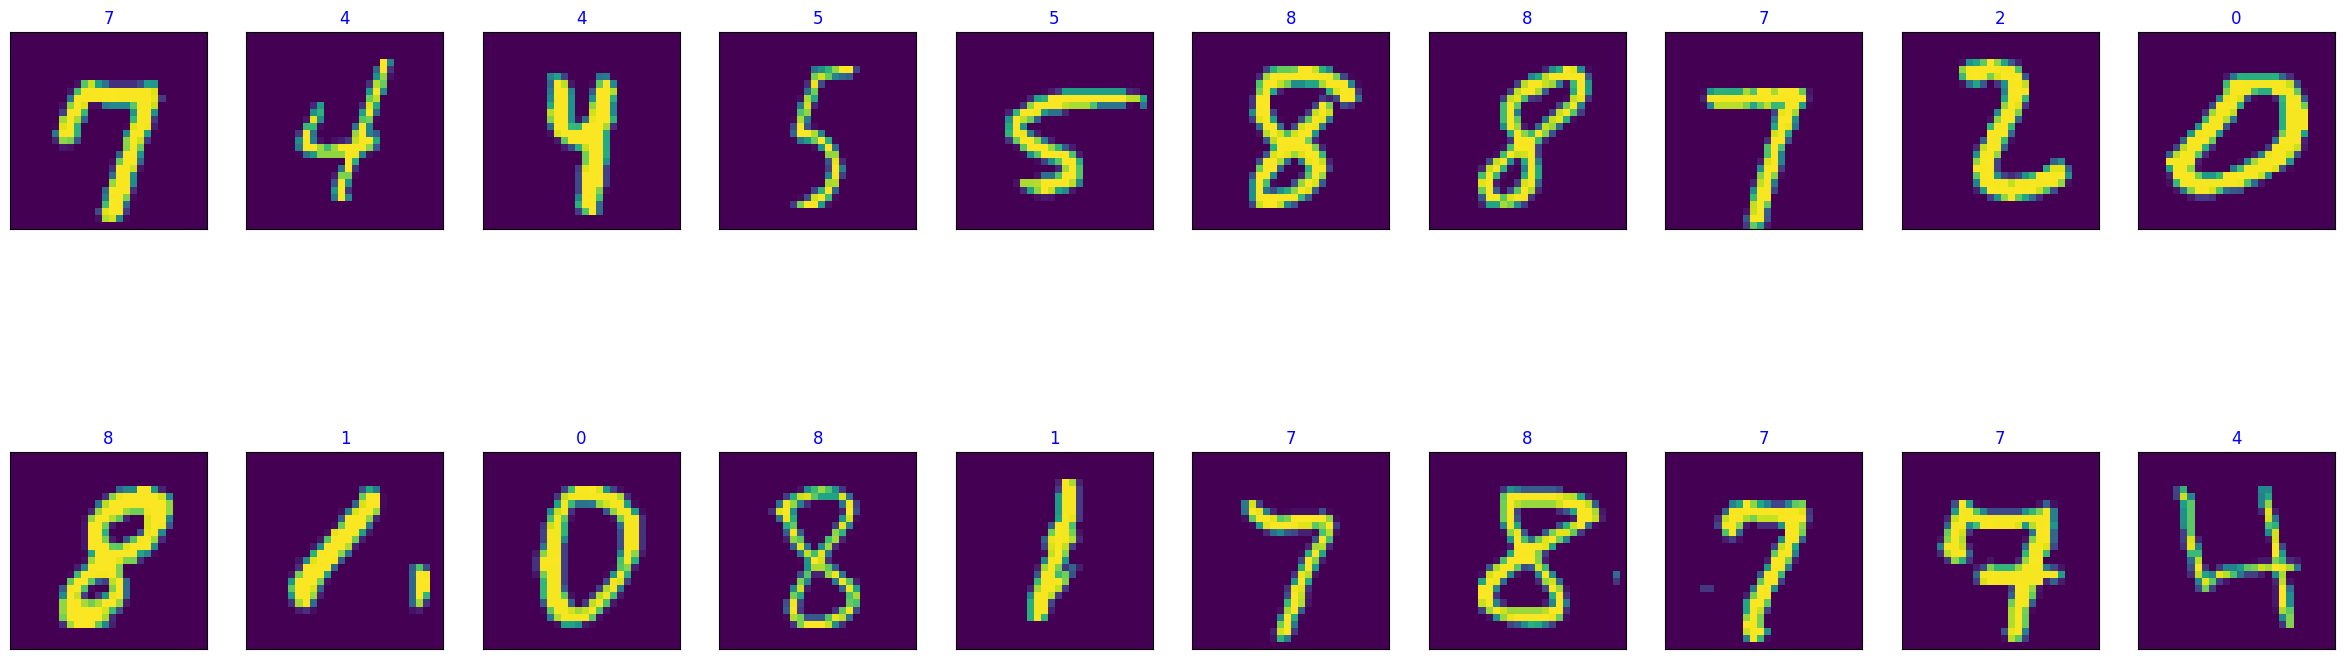

In [ ]:
# Displaying images and labels of a batch
fig=plt.figure(figsize=(30,10))
for i in range(len(labels)):
    ax=fig.add_subplot(2,10,i+1,xticks=[],yticks=[])
    plt.imshow(np.squeeze(images[i]))
    ax.set_title(labels[i].item(),color='blue')

In [ ]:
# Model 1 : This model has dropout set to a certain value
# NOTE : When we want to use dropout we ensure we run train() method on our model --- during training , if not required we should use eval() method --- validation and testing
class FNet(nn.Module):
    def __init__(self):
        super(FNet,self).__init__()
        self.fc1=nn.Linear(784,512)
        self.fc2=nn.Linear(512,256)
        self.out=nn.Linear(256,10)

        # Dropout probability - set for avoiding overfitting
        self.dropout=nn.Dropout(0.2)

    def forward(self,x):
        x = x.view(-1, 28 * 28)
        x=self.dropout(F.relu(self.fc1(x)))
        x=self.dropout(F.relu(self.fc2(x)))
        x=self.out(x)
        return x

class convNet(nn.Module):
  def __init__(self):
    super(convNet,self).__init__()
    self.conv1=nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,padding=1,stride=1)
    self.conv2=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding=1,stride=1)
    self.pool=nn.MaxPool2d(kernel_size=2,stride=2)


    self.fc1=nn.Linear(7*7*32,512)
    self.fc2=nn.Linear(512,256)
    self.out=nn.Linear(256,10)
    self.dropout=nn.Dropout(0.2)

  def forward(self,x):
    x=self.pool(F.relu(self.conv1(x)))
    x=self.pool(F.relu(self.conv2(x)))
    x=x.view(-1,7*7*32)
    x = self.dropout(x)
    x=self.dropout(F.relu(self.fc1(x)))
    x=self.dropout(F.relu(self.fc2(x)))
    x=self.out(x)
    return x

In [ ]:
model_1=FNet()
model_2=convNet()

def weight_init_normal(m):
    classname=m.__class__.__name__
    if classname.find('Linear')!=-1:
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)
model_1.apply(weight_init_normal),model_2.apply(weight_init_normal)
use_cuda=True
if use_cuda and torch.cuda.is_available():
  model_1.cuda()
  model_2.cuda()


print(model_1,'\n\n\n\n',model_2,'\n\n\n\n','On GPU : ',torch.cuda.is_available())


FNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
) 



 convNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
) 



 On GPU :  False


In [ ]:
# Loss Function
# If we did not compute softmax at output use nn.CrossentropyLoss() else use nn.NLLLoss()
criterion=nn.CrossEntropyLoss()

In [ ]:
def trainNet(model,lr):
    optimizer=torch.optim.Adam(model.parameters(),lr=lr)


    # Number of epochs to train for
    loss_keeper={'train':[],'valid':[]}
    epochs=20

    # minimum validation loss ----- set initial minimum to infinity
    valid_loss_min = np.Inf

    for epoch in range(epochs):
        train_loss=0.0
        valid_loss=0.0

        """
        TRAINING PHASE
        """
        model.train() # TURN ON DROPOUT for training
        for images,labels in train_loader:
            if use_cuda and torch.cuda.is_available():
                images,labels=images.cuda(),labels.cuda()
            optimizer.zero_grad()
            output=model(images)
            loss=criterion(output,labels)
            loss.backward()
            optimizer.step()
            train_loss+=loss.item()

        """
        VALIDATION PHASE
        """
        model.eval() # TURN OFF DROPOUT for validation
        for images,labels in valid_loader:
            if use_cuda and torch.cuda.is_available():
                images,labels=images.cuda(),labels.cuda()
            output=model(images)
            loss=criterion(output,labels)
            valid_loss+=loss.item()

        # Calculating loss over entire batch size for every epoch
        train_loss = train_loss/len(train_loader)
        valid_loss = valid_loss/len(valid_loader)


        # saving loss values
        loss_keeper['train'].append(train_loss)
        loss_keeper['valid'].append(valid_loss)
        print(f"\nEpoch : {epoch+1}\tTraining Loss : {train_loss}\tValidation Loss : {valid_loss}")
        if valid_loss<=valid_loss_min:
            print(f"Validation loss decreased from : {valid_loss_min} ----> {valid_loss} ----> Saving Model.......")
            z=type(model).__name__
            torch.save(model.state_dict(), z+'_model.pth')
            valid_loss_min=valid_loss
    return(loss_keeper)


In [ ]:
m1_loss=trainNet(model_1,0.001)


Epoch : 1	Training Loss : 0.23882449870870914	Validation Loss : 0.11769711266019536
Validation loss decreased from : inf ----> 0.11769711266019536 ----> Saving Model.......

Epoch : 2	Training Loss : 0.11811377162952946	Validation Loss : 0.09586740300061744
Validation loss decreased from : 0.11769711266019536 ----> 0.09586740300061744 ----> Saving Model.......

Epoch : 3	Training Loss : 0.09254259549988395	Validation Loss : 0.08934613512368135
Validation loss decreased from : 0.09586740300061744 ----> 0.08934613512368135 ----> Saving Model.......

Epoch : 4	Training Loss : 0.07592119563686159	Validation Loss : 0.07837932718658218
Validation loss decreased from : 0.08934613512368135 ----> 0.07837932718658218 ----> Saving Model.......

Epoch : 5	Training Loss : 0.06527489203605986	Validation Loss : 0.08512159274231332

Epoch : 6	Training Loss : 0.05941606568836183	Validation Loss : 0.09020571399695655

Epoch : 7	Training Loss : 0.05077968701393767	Validation Loss : 0.08503816487315285



In [ ]:
m1_loss

{'train': [0.23882449870870914,
  0.11811377162952946,
  0.09254259549988395,
  0.07592119563686159,
  0.06527489203605986,
  0.05941606568836183,
  0.05077968701393767,
  0.04723651722162368,
  0.043988292414846024,
  0.041176036288997214,
  0.03786145579060523,
  0.03984188253629519,
  0.04000340873191755,
  0.03582854422505925,
  0.03381562047823026,
  0.03161744500816761,
  0.029784633957312404,
  0.03212377478607506,
  0.031114505036851262,
  0.03183796147980731],
 'valid': [0.11769711266019536,
  0.09586740300061744,
  0.08934613512368135,
  0.07837932718658218,
  0.08512159274231332,
  0.09020571399695655,
  0.08503816487315285,
  0.08118503330340578,
  0.07430941974446796,
  0.08295671384767635,
  0.10140930410018731,
  0.0952193424125907,
  0.09625613824465039,
  0.09246344784272542,
  0.08801486798428722,
  0.12174327790558588,
  0.11513837292915537,
  0.12519829929317886,
  0.10668708458638056,
  0.12940779518364964]}

In [ ]:
m2_loss=trainNet(model_2,0.001)


Epoch : 1	Training Loss : 0.17904801884292587	Validation Loss : 0.048901385889403175
Validation loss decreased from : inf ----> 0.048901385889403175 ----> Saving Model.......

Epoch : 2	Training Loss : 0.0681813560112702	Validation Loss : 0.039326925120946425
Validation loss decreased from : 0.048901385889403175 ----> 0.039326925120946425 ----> Saving Model.......

Epoch : 3	Training Loss : 0.05339862021865429	Validation Loss : 0.041263863306497416

Epoch : 4	Training Loss : 0.041305178142988175	Validation Loss : 0.03869307724184637
Validation loss decreased from : 0.039326925120946425 ----> 0.03869307724184637 ----> Saving Model.......

Epoch : 5	Training Loss : 0.03661000329454547	Validation Loss : 0.03517023353742426
Validation loss decreased from : 0.03869307724184637 ----> 0.03517023353742426 ----> Saving Model.......

Epoch : 6	Training Loss : 0.029191064817843396	Validation Loss : 0.04233192235495987

Epoch : 7	Training Loss : 0.028084161003634592	Validation Loss : 0.0341847378

In [ ]:
m2_loss

{'train': [0.17904801884292587,
  0.0681813560112702,
  0.05339862021865429,
  0.041305178142988175,
  0.03661000329454547,
  0.029191064817843396,
  0.028084161003634592,
  0.023542525729662114,
  0.02209178055188817,
  0.021860235742940524,
  0.019814875450287678,
  0.0195841908589855,
  0.016812275481836895,
  0.018096021674984027,
  0.01321153820003392,
  0.01724491651962732,
  0.017179891915093403,
  0.013332609740663097,
  0.01521293536839641,
  0.014461732915847986],
 'valid': [0.048901385889403175,
  0.039326925120946425,
  0.041263863306497416,
  0.03869307724184637,
  0.03517023353742426,
  0.04233192235495987,
  0.03418473789713971,
  0.039880254368338586,
  0.044730818799249644,
  0.045577568893855114,
  0.0415943483302981,
  0.048499473129059764,
  0.05896907962894289,
  0.05299905218412972,
  0.04542294155165621,
  0.058189376786510844,
  0.04871612219976783,
  0.042348093630315976,
  0.04755117121159244,
  0.05340232764402894]}

In [ ]:
# Loading the model from the lowest validation loss
model_1.load_state_dict(torch.load('FNet_model.pth'))
model_2.load_state_dict(torch.load('convNet_model.pth'))

<ipython-input-20-22c1857e28ba>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_1.load_state_dict(torch.load('FNet_model.pth'))
<ipython-input-20-22c1857e28ba>:3: Fut

<All keys matched successfully>

In [ ]:
print(model_1.state_dict,'\n\n\n\n',model_2.state_dict)

<bound method Module.state_dict of FNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)> 



 <bound method Module.state_dict of convNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)>


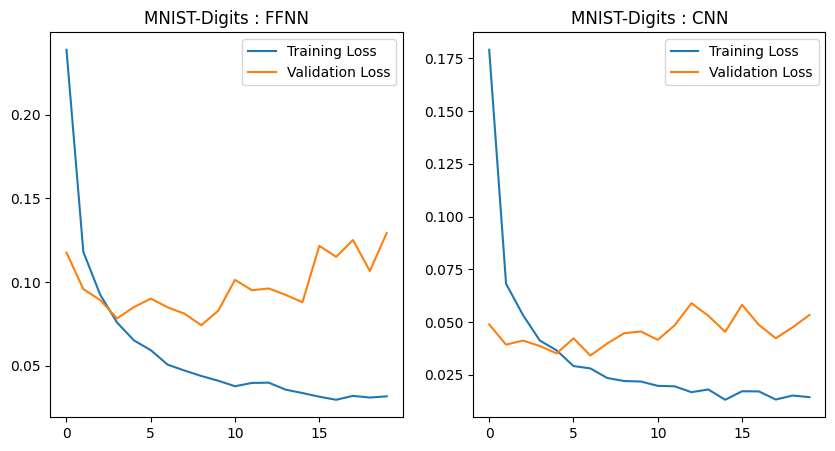

In [ ]:
title=['FFNN','CNN']
model_losses=[m1_loss,m2_loss]
fig=plt.figure(1,figsize=(10,5))
idx=1
for i in model_losses:
  ax=fig.add_subplot(1,2,idx)
  ax.plot(i['train'],label="Training Loss")
  ax.plot(i['valid'],label="Validation Loss")
  ax.set_title('MNIST-Digits : '+title[idx-1])
  idx+=1
  plt.legend();

In [ ]:
def test(model):
    correct=0
    test_loss=0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model.eval() # test the model with dropout layers off
    for images,labels in test_loader:
        if use_cuda and torch.cuda.is_available():
            images,labels=images.cuda(),labels.cuda()
        output=model(images)
        loss=criterion(output,labels)
        test_loss+=loss.item()
        _,pred=torch.max(output,1)
        correct = np.squeeze(pred.eq(labels.data.view_as(pred)))

        for i in range(batch_size):
            label = labels.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
    test_loss=test_loss/len(test_loader)
    print(f'For {type(model).__name__} :')
    print(f"Test Loss: {test_loss}")
    print(f"Correctly predicted per class : {class_correct}, Total correctly perdicted : {sum(class_correct)}")
    print(f"Total Predictions per class : {class_total}, Total predictions to be made : {sum(class_total)}\n")
    for i in range(10):
      if class_total[i] > 0:
          print(f"Test Accuracy of class {i} : {float(100 * class_correct[i] / class_total[i])}% where {int(np.sum(class_correct[i]))} of {int(np.sum(class_total[i]))} were predicted correctly")
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print(f"\nOverall Test Accuracy : {float(100. * np.sum(class_correct) / np.sum(class_total))}% where {int(np.sum(class_correct))} of {int(np.sum(class_total))} were predicted correctly")
    # obtain one batch of test images
    # dataiter = iter(test_loader)
    # images, labels = dataiter.next()
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # get sample outputs
    if use_cuda and torch.cuda.is_available():
      images,labels=images.cuda(),labels.cuda()
    output = model(images)
    # convert output probabilities to predicted class
    _, preds = torch.max(output, 1)
    # prep images for display
    images = images.cpu().numpy()
     # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(images[idx]))
        ax.set_title("{} for ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                    color=("blue" if preds[idx]==labels[idx] else "red"))


In [ ]:
test(model_1)


For FNet :
Test Loss: 0.08323297218284352
Correctly predicted per class : [965.0, 1126.0, 1017.0, 996.0, 966.0, 868.0, 936.0, 1008.0, 957.0, 970.0], Total correctly perdicted : 9809.0
Total Predictions per class : [980.0, 1135.0, 1032.0, 1010.0, 982.0, 892.0, 958.0, 1028.0, 974.0, 1009.0], Total predictions to be made : 10000.0

Test Accuracy of class 0 : 98.46938775510205% where 965 of 980 were predicted correctly
Test Accuracy of class 1 : 99.20704845814979% where 1126 of 1135 were predicted correctly
Test Accuracy of class 2 : 98.54651162790698% where 1017 of 1032 were predicted correctly
Test Accuracy of class 3 : 98.61386138613861% where 996 of 1010 were predicted correctly
Test Accuracy of class 4 : 98.37067209775968% where 966 of 982 were predicted correctly
Test Accuracy of class 5 : 97.30941704035874% where 868 of 892 were predicted correctly
Test Accuracy of class 6 : 97.7035490605428% where 936 of 958 were predicted correctly
Test Accuracy of class 7 : 98.05447470817121% whe

ValueError: Number of columns must be a positive integer, not 10.0

<Figure size 2500x400 with 0 Axes>